In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
    %matplotlib inline

    from fastai.imports import *
    from fastai.structured import *
    from pandas_summary import DataFrameSummary
    from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
    from IPython.display import display
    from sklearn import metrics

In [3]:
PATH = "data/housing/"

In [4]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Anaconda/Lib/site-packages/graphviz-2.38/release/bin/'

In [5]:
test = pd.read_csv(f'{PATH}test.csv', low_memory = False)

In [6]:
train = pd.read_csv(f'{PATH}train.csv', low_memory = False)

In [13]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
df_raw = pd.read_csv(f'{PATH}train.csv', low_memory = False)

In [9]:
df_raw = pd.concat([train, test])

In [10]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [11]:
df_raw.shape

(2919, 81)

In [12]:
df_raw.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


In [538]:
df_raw.shape

(1460, 81)

In [539]:
df_raw.drop(['Id'], axis = 1, inplace = True)

In [540]:
df_raw['Age'] = df_raw['YrSold'] - df_raw['YearBuilt']
#df_raw.drop(['YearBuilt', 'YrSold'], axis = 1, inplace = True)

In [541]:
#df_raw['TimeToLastRemod'] = df_raw.YrSold - df_raw.YearRemodAdd

In [542]:
# Months - 4,5,6,7 are PeakSeason
df_raw['PeakSeason'] = df_raw.MoSold.replace({1:0, 2:0, 3:0, 4:1, 5:1, 6:1, 7:1, 8:0, 9:0, 10:0, 11:0, 12:0})

In [543]:
# If house was Yrsold in YearBuilt, make 1
#df_raw['BuiltAndSold'] = df_raw.apply(lambda x: 'Y' if (x.YrSold == x.YearBuilt) else 'N', axis = 1)
#df_raw.BuiltAndSold.unique()

# If house was Remodeled and Sold in same year, make 1
#df_raw['RemodAndSold'] = df_raw.apply(lambda x: 'Y' if (x.YrSold == x.YearRemodAdd) else 'N', axis = 1)
#df_raw.RemodAndSold.unique()

In [544]:
#area_cols = ['LotArea', 'MasVnrArea', 'TotalBsmtSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
#            'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea']
#df_raw['TotArea'] = 0
#for x in range(len(area_cols)):
#    df_raw.TotArea += df_raw[area_cols[x]]

In [545]:
#df_raw.GrLivArea = np.log(df_raw.GrLivArea)
#df_raw.LotArea = np.log(df_raw.LotArea)

In [546]:
def mode(df, key_cols, value_col, count_col):
    return df.groupby(key_cols + [value_col]).size() \
             .to_frame(count_col).reset_index() \
             .sort_values(count_col, ascending=False) \
             .drop_duplicates(subset=key_cols)

In [597]:
fills_LotFrontage = mode(df_raw, ['Neighborhood'], 'LotFrontage', 'count').reset_index(drop = True)
fills_LotFrontage

,Neighborhood,LotFrontage,count
0,NAmes,70.0,70
1,OldTown,60.0,46
2,NWAmes,80.0,43
3,CollgCr,65.0,37
4,Gilbert,65.0,34
5,Sawyer,70.0,34
6,Edwards,60.0,26
7,Somerst,75.0,22
8,BrkSide,50.0,22
9,ClearCr,80.0,18


In [548]:
for x in range(len(df_raw)):
    if pd.isnull(df_raw.loc[x, 'LotFrontage']):
        Neigh = df_raw.loc[x, 'Neighborhood']
        for y in range(len(fills_LotFrontage)):
            if (fills_LotFrontage.loc[y, 'Neighborhood'] == Neigh):
                df_raw.loc[x, 'LotFrontage'] = fills_LotFrontage.loc[y, 'LotFrontage']

In [549]:
df_raw.MSSubClass = df_raw.MSSubClass.astype('object')

In [550]:
train_cats(df_raw)
#display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

In [551]:
df_raw.to_feather('tmp/housing-raw')

In [552]:
df, y, nas = proc_df(df_raw, 'SalePrice', max_n_cat = 15)

In [553]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df,y)

0.9776758098074467

In [554]:
df.shape
y = np.log(y)

C:\Users\santh\AppData\Local\conda\conda\envs\fastai\lib\site-packages\matplotlib\axes\_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


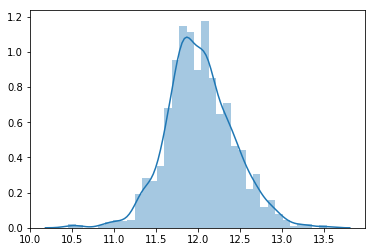

In [555]:
import seaborn as sns
sns.distplot(y)

In [556]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 500  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((960, 309), (960,), (500, 309))

In [557]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [558]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 128 ms
[0.06690710318583762, 0.15989301497278527, 0.9726958690914429, 0.8302210967209681]


In [559]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.20998924597432028, 0.23114014858380758, 0.7310459975803244, 0.6452066128347507]


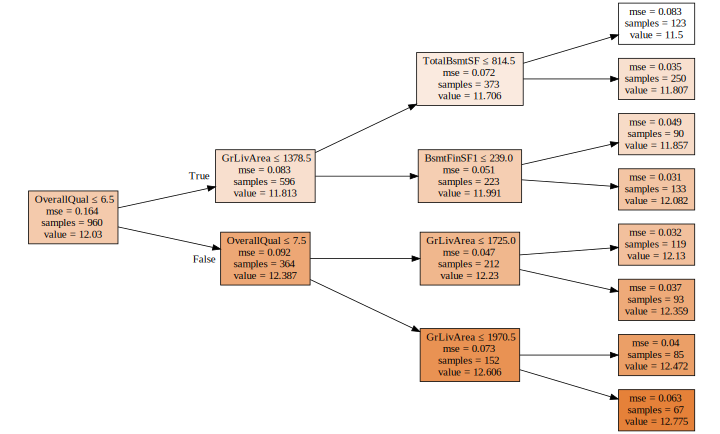

In [560]:
draw_tree(m.estimators_[0], df, precision=3)

In [561]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[3.101099345283839e-05, 0.20727252287914516, 0.9999999941343618, 0.714695772061195]


In [562]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.05912800130100902, 0.14642149422406528, 0.9786759201041719, 0.8576247796065706]


In [563]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([11.79056, 11.83863, 11.72481, 11.72804, 11.66135, 11.77144, 11.73206, 11.77529, 11.78676, 11.82408,
        11.73206, 11.60824, 11.73607, 11.83863, 11.75587, 11.58989, 11.68267, 11.60824, 11.3621 , 11.77529]),
 11.716102272638029,
 11.665646551987892)

In [564]:
preds.shape

(20, 500)

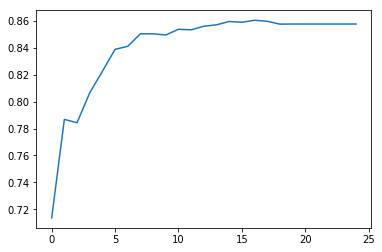

In [599]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(25)]);

In [566]:
m = RandomForestRegressor(n_estimators=600, n_jobs=-1, oob_score=True, min_samples_leaf = 2, max_features = 0.5)
m.fit(X_train, y_train)
print_score(m)

[0.06586062850366872, 0.1398039477044153, 0.9735433016869098, 0.87020331215611, 0.876083494481972]


In [687]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(min_samples_split = 0.001, min_samples_leaf = 20, max_depth = 15, 
                                n_estimators = 4000, max_features = 0.5, subsample = 1.0, learning_rate = 0.015,
                               random_state = 500)
gbm.fit(X_train, y_train)
print_score(gbm)

[0.005083871006044108, 0.12973650500717912, 0.9998423576324913, 0.8882238546186113]


In [688]:
from sklearn import cross_validation, metrics 

In [689]:
cv_score_gbm = cross_validation.cross_val_score(gbm, df, y, cv=5); cv_score_gbm

array([0.90416, 0.89778, 0.89076, 0.9014 , 0.89592])

In [690]:
np.mean(cv_score_gbm)

0.8980017752879625

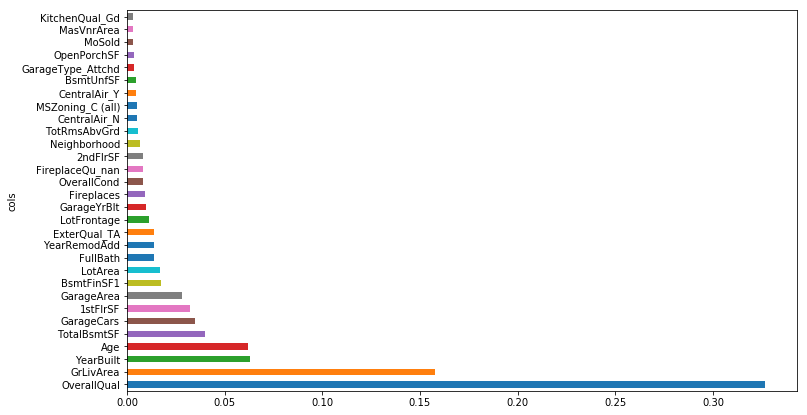

In [600]:
fi = rf_feat_importance(m, X_train); fi[:30]
plot_fi(fi[:30])

In [572]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)
df_keep = X_train[to_keep].copy()

In [573]:
df_keep.shape

(960, 23)

In [574]:
def print_score_new(m):
    res = [rmse(m.predict(df_keep), y_train), rmse(m.predict(X_valid[df_keep.columns]), y_valid),
                m.score(df_keep, y_train), m.score(X_valid[df_keep.columns], y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [575]:
m_new = RandomForestRegressor(n_estimators=6000, n_jobs=-1, oob_score=True,  max_features = 0.5,
                              min_samples_leaf = 2)
m_new.fit(df_keep, y_train)
print_score_new(m_new)

[0.0685762183979782, 0.13754685084259555, 0.9713165776094511, 0.8743605450786299, 0.8770800223373958]


In [576]:
cv_rf_score_new = cross_validation.cross_val_score(m_new, df[df_keep.columns], y, cv=5); cv_rf_score_new

array([0.88634, 0.87375, 0.88245, 0.89952, 0.87059])

In [577]:
np.mean(cv_rf_score_new)

0.8825307150790083

C:\Users\santh\AppData\Local\conda\conda\envs\fastai\lib\site-packages\matplotlib\axes\_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


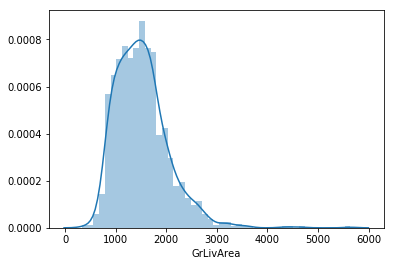

In [578]:
import seaborn as sns
sns.distplot(df_raw['GrLivArea'])

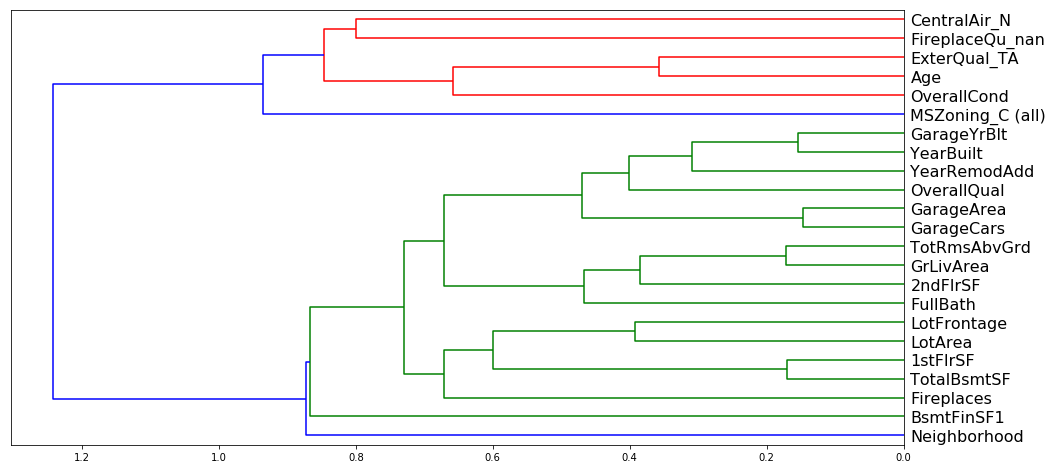

In [605]:
from scipy.cluster import hierarchy as hc
corr = np.round(scipy.stats.spearmanr(df[df_keep.columns]).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,8))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [580]:
fi_gbm = rf_feat_importance(gbm, X_train)
fi_gbm.head()

,cols,imp
1,LotArea,0.160238
29,OpenPorchSF,0.091304
16,GrLivArea,0.075020
13,1stFlrSF,0.066939
0,LotFrontage,0.046763


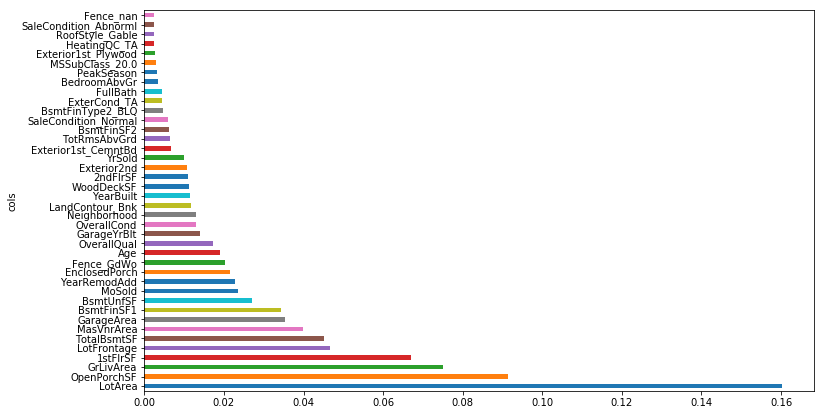

In [581]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi_gbm[:40])

In [582]:
to_keep_gbm = fi_gbm[fi_gbm.imp>0.005].cols; len(to_keep)
to_keep_gbm

1                   LotArea
29              OpenPorchSF
16                GrLivArea
13                 1stFlrSF
0               LotFrontage
12              TotalBsmtSF
8                MasVnrArea
27               GarageArea
9                BsmtFinSF1
11                BsmtUnfSF
35                   MoSold
6              YearRemodAdd
30            EnclosedPorch
283              Fence_GdWo
37                      Age
3               OverallQual
25              GarageYrBlt
4               OverallCond
2              Neighborhood
74          LandContour_Bnk
5                 YearBuilt
28               WoodDeckSF
14                 2ndFlrSF
7               Exterior2nd
36                   YrSold
147     Exterior1st_CemntBd
23             TotRmsAbvGrd
10               BsmtFinSF2
306    SaleCondition_Normal
Name: cols, dtype: object

In [583]:
df_keep_gbm = X_train[to_keep_gbm].copy()

In [584]:
def print_score_new_gbm(m):
    res = [rmse(m.predict(df_keep_gbm), y_train), rmse(m.predict(X_valid[df_keep_gbm.columns]), y_valid),
                m.score(df_keep_gbm, y_train), m.score(X_valid[df_keep_gbm.columns], y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [585]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [586]:
#165 without learning_rate 
#5000 with learning_rate 0.01, max_features = 0.5, subsample = 0.8, min_sample_split = 25, 89.18%
#5000 with learning_rate 0.01, max_features = sqrt, subsample = 0.8, min_sample_split = 25, 89.25%
#5000 with learning_rate 0.01, max_features = log2, subsample = 0.8, min_sample_split = 25, 89.14%
#6000 with learning_rate 0.01, max_features = sqrt, subsample = 0.8, min_sample_split = 25, 89.20%
#6000 max_features = sqrt, subsample = 0.8, min_sample_split = 25, 89.24%, learn = 0.0085
#6000 max_features = sqrt, subsample = 0.8, min_sample_split = 25, 89.30%, learn = 0.0075
#7050 max_features = sqrt, subsample = 0.8, min_sample_split = 25, 89.23%, learn = 0.0077
#3390 max_features = sqrt, subsample = 0.8, min_sample_split = 25, 89.33%, learn = 0.0077

In [587]:
old_params = clf.cv_results_

In [588]:
param_test = {'n_estimators': range(1000, 3390, 10)}

In [589]:
#clf = GridSearchCV(param_grid = param_test, estimator = GradientBoostingRegressor(min_samples_split = 25, 
 #                   max_features = 'sqrt', subsample = 0.8, random_state = 500, learning_rate = 0.0077))
#clf.fit(df[df_keep_gbm.columns], y)
#print(clf.best_params_)
#means = clf.cv_results_['mean_test_score']
#print(means)
#print_score_new_gbm(gsearch)

In [684]:

gbm_new = GradientBoostingRegressor(n_estimators = 4300,  min_samples_leaf = 1, min_samples_split = 10,
                                    learning_rate = 0.015, 
                                    max_features = 'sqrt', subsample = 0.8, random_state = 500)
gbm_new.fit(df_keep_gbm, y_train)
print_score_new_gbm(gbm_new)

[0.032022395122152394, 0.12976398425951965, 0.9937455154033069, 0.8881764994013353]


In [685]:
cv_score_gbm_new = cross_validation.cross_val_score(gbm_new, df[df_keep_gbm.columns], y, cv=5); cv_score_gbm_new

array([0.90276, 0.88677, 0.89001, 0.90039, 0.88801])

In [686]:
np.mean(cv_score_gbm_new)

0.8935888595910806

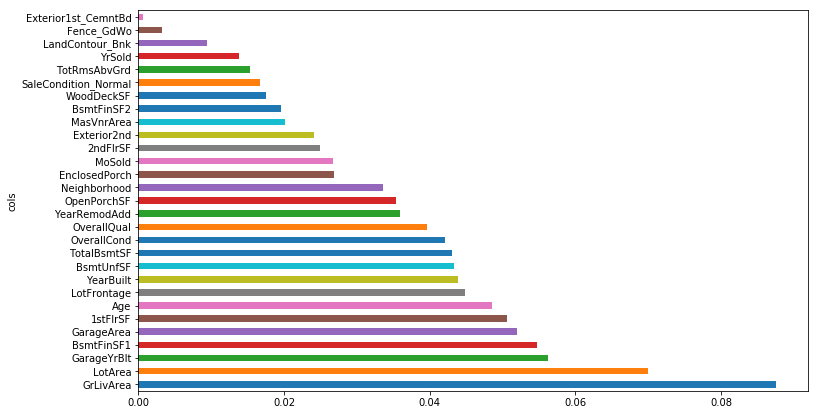

In [593]:
fi_gbm_new = rf_feat_importance(gbm_new, df[df_keep_gbm.columns])
plot_fi(fi_gbm_new[:40])

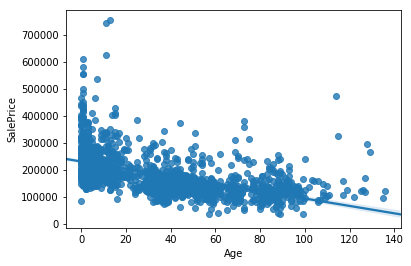

In [595]:
sns.regplot(df_raw['Age'], df_raw['SalePrice'])

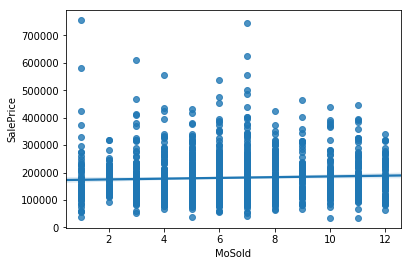

In [596]:
sns.regplot(df_raw['MoSold'], df_raw['SalePrice'])